# 1.1 Cleaning data

In [139]:
import pandas as pd

df = pd.read_csv('price_history.csv')
df.dropna(inplace = True)

df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
df = df.sort_values(by='Date') #ascending
df = df.reset_index(drop=True)

def convert_currency1(value):
    value = value.replace('$', '').strip()
    if 'K' in value:
        return float(value.replace(' K', '').strip()) * 1e3 
    elif 'm' in value:
        return float(value.replace(' m', '').strip()) * 1e6
    elif 'bn' in value:
        return float(value.replace(' bn', '').strip()) * 1e9 
    else:
        return float(value)

def convert_currency2(value):
    return float(value.replace('$', '').strip())

#Remove symbols and convert to numbers only
for column in ['Open', 'High', 'Low', 'Close']:
  df[column] = df[column].apply(convert_currency2)

for column1 in ['Volume','Market Cap']:
    df[column1] = df[column1].apply(convert_currency1)

df['Volume(BAT)'] = df['Volume(BAT)'].astype(int)

print(df.head())

df.to_csv('cleaned_data.csv', index=False)

        Date    Open    High     Low   Close      Volume  Volume(BAT)  \
0 2017-06-01  0.1682  0.1753  0.1462  0.1710   4400000.0     26476554   
1 2017-06-02  0.1712  0.1712  0.1535  0.1566   3100000.0     19137034   
2 2017-06-03  0.1565  0.1851  0.1547  0.1660   4700000.0     28611949   
3 2017-06-04  0.1660  0.3524  0.1649  0.2855  27600000.0    113864756   
4 2017-06-05  0.2850  0.3299  0.2698  0.2917  14300000.0     48616308   

    Market Cap  
0          0.0  
1  178400000.0  
2  156100000.0  
3  140800000.0  
4  287400000.0  


# 1.2 Preparing the Random Forest Model

In [145]:
from sklearn.model_selection import train_test_split

x = df[['Open','High','Low','Close','Volume','Volume(BAT)','Market Cap']]
y = df['Close']

test_size = int(len(df) * 0.2)
split_index = len(df) - test_size

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
#Last 20% train
print(x_train.dtypes)

Open           float64
High           float64
Low            float64
Close          float64
Volume         float64
Volume(BAT)      int64
Market Cap     float64
dtype: object


# 1.3 Train model

In [143]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

# 1.4 Evaluate model

In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_predict = model.predict(x_test)

mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)


print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

x_future = x[-10:]
y_future_prediction = model.predict(x_future)

print("Prediction:",y_future_prediction)
print("Actual:",y[-10:])

Mean Absolute Error: 3.512713472485168e-05
Mean Squared Error: 3.004049335861963e-09
R-squared: 0.9999984512306365
Prediction: [0.17752  0.186522 0.190097 0.187543 0.178085 0.169301 0.164575 0.165066
 0.165633 0.163732]
Actual: 9    0.1775
8    0.1865
7    0.1901
6    0.1875
5    0.1781
4    0.1693
3    0.1646
2    0.1651
1    0.1656
0    0.1637
Name: Close, dtype: float64


# 1.5 Backtesting

Test start and end dates: 2023-03-23 00:00:00 2024-08-31 00:00:00


Text(0.5, 1.0, 'Actual vs Predicted')

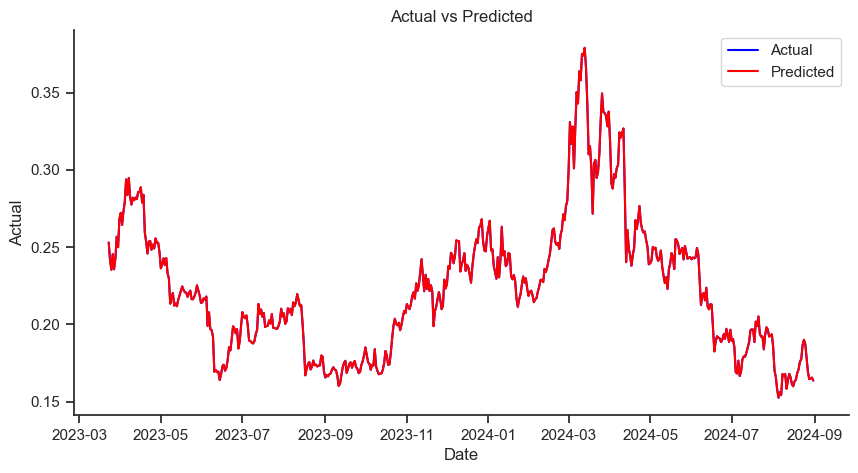

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea; sea.set()

#New dataframe for test set and predictions
df_test = df.loc[y_test.index]
print("Test start and end dates:",first_test_date, last_test_date)

#Add to new test dataframe
df_test['Predicted'] = y_predict
df_test['Actual'] = y_test

plt.figure(figsize=(10,5))
sea.set_style('ticks')
sea.lineplot(data=df_test, x='Date', y='Actual', color='blue', label='Actual')
sea.lineplot(data=df_test, x='Date', y='Predicted', color='red', label='Predicted')
sea.despine()
plt.title('Actual vs Predicted')

# 2.1 Make Predictions with Prophet

01:43:03 - cmdstanpy - INFO - Chain [1] start processing
01:43:04 - cmdstanpy - INFO - Chain [1] done processing


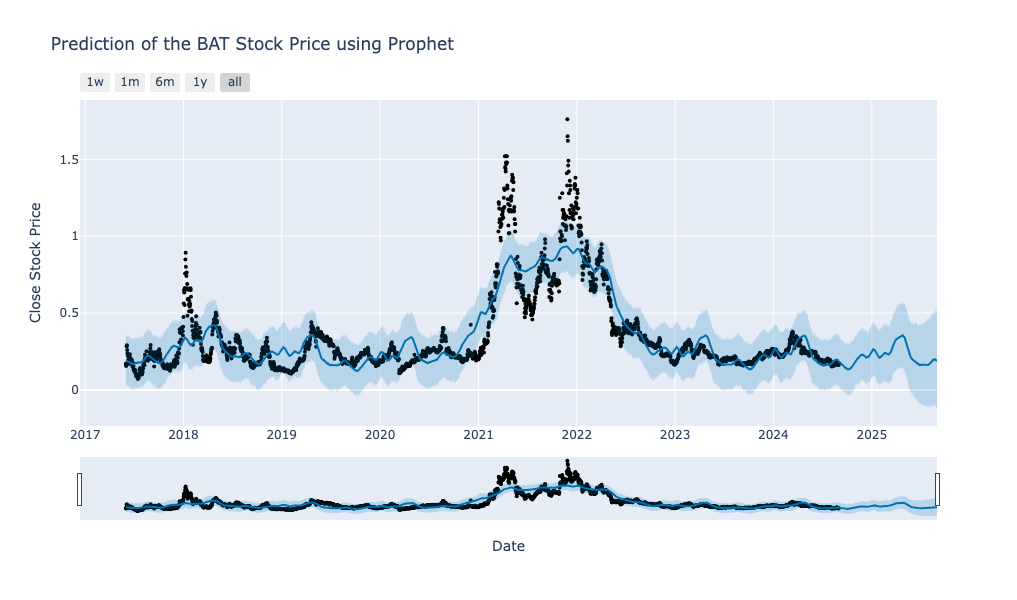

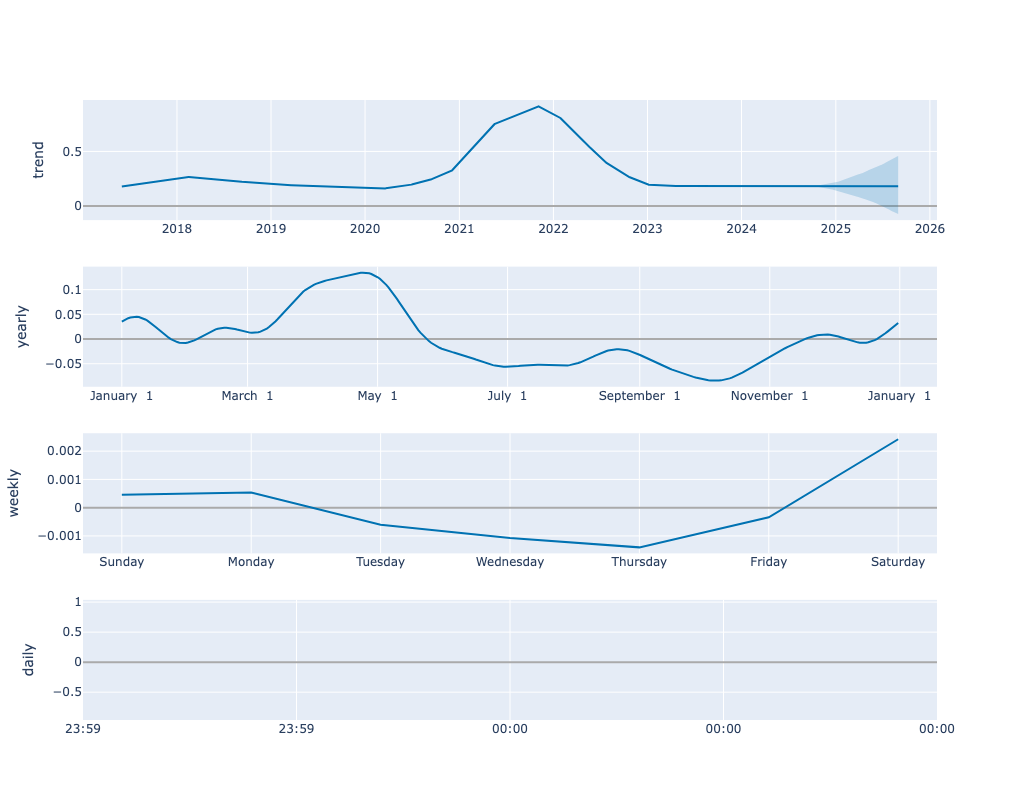

In [207]:
from prophet import Prophet
import pandas as pd
import plotly.graph_objs as go
from prophet.plot import plot_plotly, plot_components_plotly

# Initialize and fit the Prophet model
m = Prophet(daily_seasonality=True)
df = df.rename(columns={"Date": "ds", "Close": "y"})
m.fit(df)

# Create a future dataframe and make predictions
future = m.make_future_dataframe(periods=365)
prediction = m.predict(future)

# Plot the forecast using plotly
fig = plot_plotly(m, prediction)
fig.update_layout(title="Prediction of the BAT Stock Price using Prophet",
                  xaxis_title="Date",
                  yaxis_title="Close Stock Price")
fig.show()

# Optional: Plot the individual components (trend, yearly seasonality, etc.)
fig_components = plot_components_plotly(m, prediction)
fig_components.show()
